# Current constituents of VN30


In [25]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

In [26]:
all_data = pd.read_csv("VN30_data.csv", index_col=0, parse_dates=True)
all_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,ADX_15,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,25.093592,45.034483,72.526715,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,25.703732,100.000000,100.000000,69.677010,63.185447,1.102738,81.871143,68.653723,1.192523,655.267330
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,26.701074,80.752916,89.991729,70.825870,67.090601,1.055675,85.373348,70.858164,1.204848,785.277116
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,27.078960,73.064687,85.993934,70.437084,69.642131,1.011415,77.862786,68.787792,1.131927,798.187944
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.958253,...,27.431653,65.167866,83.981252,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,34650.0,34900.0,33150.0,34000.0,12182800,VRE,-0.025788,34220.0,34620.000000,1.011689,...,11.822802,36.956522,31.325301,59.885884,52.557598,1.139433,43.861083,50.799622,0.863414,55.787953
2022-02-25,34400.0,34500.0,34000.0,34000.0,4080500,VRE,0.000000,34300.0,34556.666667,1.007483,...,11.259089,36.956522,31.325301,58.496701,49.535255,1.180910,43.861083,50.799622,0.863414,-14.422548
2022-02-28,34000.0,34200.0,33500.0,33500.0,5203100,VRE,-0.014706,34180.0,34423.333333,1.007119,...,11.087806,15.217391,20.000000,47.881643,45.421543,1.054162,35.174406,48.262017,0.728822,-158.944401


In [27]:
len(set(all_data['Symbol']))

29

In [28]:
print(set(all_data['Symbol']))

{'VRE', 'HDB', 'GAS', 'TCB', 'PLX', 'KDH', 'VIC', 'PNJ', 'FPT', 'BID', 'MWG', 'VCB', 'POW', 'TPB', 'ACB', 'GVR', 'BVH', 'MBB', 'MSN', 'VNM', 'SSI', 'NVL', 'PDR', 'SAB', 'HPG', 'VJC', 'CTG', 'VHM', 'VPB'}


# Creating Prediction variable

Now that we have formed all the variables that will be used in predicting the stock movement, we need to define the prediction variable.
Technical Indicators generally work well in short interval predictions and since our indicators have been based on 5-day and 15-day periods, I use a 7 (trading) days prediction interval. Thus, the idea is to observe the technical indicators for today and use it to predict the direction of movement of the stocks 7 days later. If the stock went up in 7 days, we denote it by 1 and if it went down/did not change, we denote it by 0 (“Target_Direction”). In order to make this even more comprehensive, let us look at it from a real-world point of view. If we look at the indicators today, we will buy the next day’s opening price and hold for 7 trading days, including the day we bought, and sell at the Closing 7 days later. Thus, in our code, we will have to shift the price by just 6 days. Our profit will be the difference between our buy (Opening price of day 1) and sell (Closing price of day 7)
In the below code, we define the Target variable as the percentage profit defined above. This is transformed into a Target Direction (1 or 0) variable as described above, which forms our prediction variable.


In [29]:
Target_variables = ['SMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])

In [30]:
all_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,ADX_15,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,25.093592,45.034483,72.526715,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,25.703732,92.329280,91.438122,69.677010,63.185447,1.102738,79.824566,68.496611,1.192523,655.267330
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,26.701074,80.752916,89.991729,70.825870,67.090601,1.055675,79.824566,68.496611,1.204848,785.277116
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,27.078960,73.064687,85.993934,70.437084,69.642131,1.011415,77.862786,68.496611,1.131927,798.187944
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.961256,...,27.431653,65.167866,83.981252,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,34650.0,34900.0,33150.0,34000.0,12182800,VRE,-0.025788,34220.0,34620.000000,1.011689,...,13.815142,36.956522,31.325301,59.885884,52.557598,1.139433,43.861083,50.799622,0.863414,55.787953
2022-02-25,34400.0,34500.0,34000.0,34000.0,4080500,VRE,0.000000,34300.0,34556.666667,1.007483,...,13.815142,36.956522,31.325301,58.496701,49.535255,1.180910,43.861083,50.799622,0.863414,-14.422548
2022-02-28,34000.0,34200.0,33500.0,33500.0,5203100,VRE,-0.014706,34180.0,34423.333333,1.007119,...,13.815142,15.217391,20.000000,47.881643,45.421543,1.054162,35.174406,48.262017,0.728822,-158.944401


In [31]:
all_data[['Open','High', 'Low', "Close", "Volume", "Symbol"]].groupby('Symbol').describe()

Open                                                              \
         count           mean           std       min        25%       50%   
Symbol                                                                       
ACB     3773.0   17165.945455   6945.622823    7288.0   12298.00   14708.0   
BID     1987.0   21889.614997   9903.471493    8006.4   12324.00   20932.1   
BVH     3136.0   56726.555804  17351.298434   21146.0   42790.50   55500.0   
CTG     3121.0   19749.646588   5693.295083   11330.0   16300.00   18043.0   
FPT     2127.0   42592.712976  17567.875280   27686.0   32974.00   36295.0   
GAS     2135.0   81052.501171  21858.882792   30100.0   64000.00   81000.0   
GVR      948.0   18172.424051  10464.789037    7190.0   10243.00   12827.0   
HDB     1004.0   21949.671614   9067.180294    8484.8   13957.55   19241.2   
HPG     2131.0   24756.801830  10721.525091    9249.2   16501.25   20870.0   
KDH     2143.0   20829.104060   8811.694008    8900.0   15082.00   19145.0   
MBB     2120.0   17738.469340   6103.368978   11589.0   13238.00   15652.5   
MSN     2115.0   74904.244444  27898.825520   39333.0   50333.00   77200.0   
MWG     1877.0   54950.740011  31130.283354   13687.0   30510.00   54373.0   
NVL     1260.0   41064.665079  18536.768207   25352.0   29767.25   33764.5   
PDR     2056.0   25076.768482  23096.542840    7838.0   12899.00   16869.0   
PLX     1185.0   58402.707173   9428.116984   35100.0   52800.00   57300.0   
PNJ     3191.0   46473.787590  25810.027780   12500.0   23846.00   39000.0   
POW      960.0   12903.416667   2332.345348    7000.0   10937.50   12950.0   
SAB     1276.0  212383.166144  42102.663708  112000.0  176975.00  213000.0   
SSI     3746.0   11916.540897   8408.674834    2816.4    6727.90   10115.2   
TCB      908.0   31022.797357  12055.751513   15000.0   22100.00   25800.0   
TPB      937.0   17919.163394   8165.596167    9670.0   12762.00   13641.1   
VCB     3133.0   31872.850942  23198.805386    7887.0   12370.00   23438.0   
VHM      919.0   67647.150163   9922.167817   40482.0   60132.00   65745.0   
VIC     2130.0   65477.052582  32675.040341   26424.0   34380.00   58925.5   
VJC     1222.0  121678.079378  22813.654568   71048.0  111105.50  123350.0   
VNM     2128.0  102591.997180  21397.070766   64236.0   88333.00   99167.0   
VPB     1103.0   18240.922393   9328.847744    9416.8   11833.50   13500.1   
VRE     1044.0   32074.853448   4634.176362   17700.0   28700.00   31900.0   

                                High                 ...       Close  \
               75%       max   count           mean  ...         75%   
Symbol                                               ...               
ACB      19842.000   43572.0  3773.0   17406.696422  ...   19764.000   
BID      31130.100   49500.0  1987.0   22233.185858  ...   31103.200   
BVH      65000.000  109400.0  3136.0   57631.184949  ...   65000.000   
CTG      20800.000   42225.0  3121.0   20016.074335  ...   20800.000   
FPT      42021.500  100100.0  2127.0   43044.002727  ...   42077.350   
GAS      99000.000  136100.0  2135.0   82143.414988  ...   98900.000   
GVR      28262.500   43300.0   948.0   18572.612869  ...   28300.000   
HDB      28019.225   50067.0  1004.0   22252.369223  ...   28010.000   
HPG      31014.000   58000.0  2131.0   25092.765462  ...   31252.000   
KDH      22278.000   57000.0  2143.0   21091.813952  ...   22292.000   
MBB      19731.000   43800.0  2120.0   17950.879953  ...   19765.000   
MSN      88650.000  172000.0  2115.0   75939.170686  ...   88900.000   
MWG      70860.000  144800.0  1877.0   55627.510922  ...   71056.000   
NVL      38941.000   93969.0  1260.0   41551.504762  ...   38941.000   
PDR      21540.500   99000.0  2056.0   25425.355885  ...   21561.075   
PLX      62700.000   94200.0  1185.0   59170.312236  ...   62600.000   
PNJ      70133.000  111000.0  3191.0   47079.344437  ...   70133.000   
POW      14400.000   20500.0   960.0   13112.302083  ...   14400.000   
S

In [32]:
len(set(all_data['Symbol']))

29

# Winsorizing the Indicators

In [33]:
all_data['Close_Shifted'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.shift(-6))
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100).shift(-1)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

In [34]:
all_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459,23238.0,5.331722,1
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,69.677010,63.185447,1.102738,79.824566,68.496611,1.192523,655.267330,23529.0,4.622591,1
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,70.825870,67.090601,1.055675,79.824566,68.496611,1.204848,785.277116,23674.0,4.913714,1
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,70.437084,69.642131,1.011415,77.862786,68.496611,1.131927,798.187944,23892.0,3.956440,1
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.961256,...,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097,23674.0,7.643731,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,33000.0,34000.0,32700.0,34000.0,8107200,VRE,0.030303,34700.0,34110.000000,0.982997,...,34.472028,50.415762,0.683755,44.765089,51.806048,0.864090,101.808515,34900.0,-0.584795,0
2022-02-16,34200.0,34450.0,33750.0,34300.0,4748300,VRE,0.008824,34380.0,34180.000000,0.994183,...,28.318182,50.626288,0.559357,48.965481,52.980621,0.924215,89.673589,34000.0,-0.874636,0
2022-02-17,34300.0,34750.0,34000.0,34450.0,3764700,VRE,0.004373,34070.0,34236.666667,1.004892,...,25.269231,49.841032,0.506997,51.281031,53.586608,0.956975,110.108482,34000.0,-1.470588,0


In [35]:
# all_data[Target_variables] = all_data.groupby('Symbol')[Target_variables].shift(1)
# all_data.dropna(inplace=True)
# all_data

In [36]:
all_data.head(10)

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459,23238.0,5.331722,1
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,69.677010,63.185447,1.102738,79.824566,68.496611,1.192523,655.267330,23529.0,4.622591,1
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,70.825870,67.090601,1.055675,79.824566,68.496611,1.204848,785.277116,23674.0,4.913714,1
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,70.437084,69.642131,1.011415,77.862786,68.496611,1.131927,798.187944,23892.0,3.956440,1
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.961256,...,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097,23674.0,7.643731,1
2007-01-10,22803.0,23238.0,22803.0,23093.0,290774,ACB,0.020550,22750.2,21680.733333,0.961256,...,81.837634,72.258946,1.132561,79.824566,68.496611,1.150999,798.697223,24546.0,10.938979,1
2007-01-11,23238.0,23238.0,22657.0,23238.0,377105,ACB,0.006279,22901.2,21832.600000,0.961256,...,81.837634,73.689392,1.110576,79.824566,68.496611,1.163044,819.802246,25780.0,11.512623,1
2007-01-12,23965.0,23965.0,22948.0,23529.0,280466,ACB,0.012523,23037.8,22008.666667,0.961256,...,81.138277,74.595858,1.087705,79.824566,68.496611,1.181432,858.580082,26724.0,21.253981,1
2007-01-15,23238.0,23674.0,23238.0,23674.0,193706,ACB,0.006163,23232.4,22237.933333,0.961256,...,82.948204,77.342493,1.072479,79.824566,68.496611,1.187937,875.634650,28177.0,23.924981,1


In [37]:
len(set(all_data['Symbol']))

29

# Clustering companies

This is where things start to get interesting. A simple way of predicting would be to assume that all the companies would follow the same ML model and create this one global model to predict returns for all companies. However, it is possible that different companies/industries react differently to a set of Technical Indicator. One way to solve this problem is to create different ML model for each cluster of companies that are expected to behave similarly perhaps belonging to the same industry, where the “behavior” is captured in their returns.
Thus, to make our model even more sophisticated, we will create different ML models for each cluster.

# Identify number of clusters

The idea is to use returns of these companies and create an elbow curve to determine the number of clusters that would create a balance between low sum of squares within a cluster vs the total number of clusters. For 30 companies, if we create 30 clusters, we would get 0 sum of squares within the cluster however this clustering would not make sense, i.e. would not be parsimonious. On the other hand, having 1 cluster would be parsimonious however will lead to very high sum of squares within cluster. An elbow curve helps to determine the approximate point at which the marginal decrease in sum of squares is small.
We use K-means clustering to create an elbow curve. K-means aims at minimizing the inertia or the within cluster sum of squares while clustering. By providing a range of clusters from 1 to 20, we create the required elbow curve.

In [38]:
all_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Symbol', 'Return', 'SMA_5',
       'SMA_15', 'SMA_ratio', 'SMA5_Volume', 'SMA15_Volume',
       'SMA_Volume_Ratio', 'ATR_5', 'ATR_15', 'ATR_Ratio', 'ADX_5', 'ADX_15',
       'Stochastic_5', 'Stochastic_15', 'Stochastic_%D_5', 'Stochastic_%D_15',
       'Stochastic_Ratio', 'RSI_5', 'RSI_15', 'RSI_ratio', 'MACD',
       'Close_Shifted', 'Target', 'Target_Direction'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, ACB to VRE
Columns: 878 entries, 2018-07-16 to 2022-02-17
dtypes: float64(878)
memory usage: 200.4+ KB
None


,Difference in SS
1,NaN
2,-0.670378
3,-0.615464
4,-0.322919
5,-0.324652
6,-0.230967
7,-0.349718
8,-0.299537
9,-0.301850
10,-0.243576


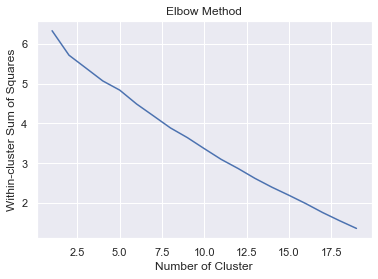

In [39]:
#Extract the returns
returns = all_data[['Symbol','Return']].copy()
returns['Date'] = returns.index.copy()

#Pivot the returns to create series of returns for each stock
transposed = returns.pivot(index = 'Date', columns = 'Symbol', values = 'Return')

#Transpose the data to get companies on the index level and dates on the column level since clusters takes place on index level
X = transposed.dropna().transpose()
print(X.info())
#Extract sum of squares for K-means clusters from 1 to 50 clusters
n = 20
sum_of_sq = np.zeros([n, 1])

for k in range(1, n+1):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(X).inertia_

plt.plot(range(1, n), sum_of_sq[1:n])
plt.title("Elbow Method")
plt.xlabel("Number of Cluster")
plt.ylabel("Within-cluster Sum of Squares")

pd.DataFrame(sum_of_sq, columns = ['Difference in SS'], index = range(1,n+1)).diff()

Thus, we can see from the above curves and the table that 10 clusters best serve our purpose. The decrease in sum of squares after 10 is not large enough. Hence, for our analysis, we select 10 clusters.

# Creating clusters

We now use the Guassian Mixture clustering algorithm to assign the companies to 10 clusters based on their returns. Gaussian Mixture is an uses a probabilistic method of determining the appropriate cluster for a series of observation, assuming the universe is formed out of different Gaussian distributions.
The code below provides us a dataframe with different clusters and the companies that fall in each cluster.

In [40]:
#Get 10 clusters
gmm = GaussianMixture(n_components = 10)
gmm.fit(transposed.dropna().transpose())

#Predict for each company
clusters = gmm.predict(transposed.dropna().transpose())
clusters_df = pd.DataFrame({'Cluster':clusters,
                           'Companies':transposed.columns})

#Sort by Clusters
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop = True)

#Save as csv
clusters_df.to_csv("clusters.csv")
clusters_df = pd.read_csv("clusters.csv", index_col = 0)

The clustering resulted in, to a large extent, an industry wide classification of stocks which is in line with our initial thought.

# Random Forest model

Random Forest is a commonly used Machine Learning model for Regression and Classification problems. However, given the complexity of the model, it is important to carefully understand the parameters that go into the model to prevent in-sample overfitting or underfitting, a standard bias-variance tradeoff.
There are quite a few things to consider while forming a Machine Learning model.

# Training period

We will first separate our data into a train and a test sample. While scipy offers a TrainTestSplit function, we will not use that here since our data is a time series data and we want to split the Train-Test as a timeline rather than randomly selecting observations as train or test. We first convert our index into a date time index and split the data to before and after 31st December 2020.
Train period: to 31st December 2020
Test period: 1st January 2021 — now

In [41]:
all_data.index = pd.to_datetime(all_data.index)

train_data = all_data.loc[:'2020-12-31',]
test_data = all_data.loc['2021-01-01':]

In [42]:
train_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459,23238.0,5.331722,1
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,69.677010,63.185447,1.102738,79.824566,68.496611,1.192523,655.267330,23529.0,4.622591,1
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,70.825870,67.090601,1.055675,79.824566,68.496611,1.204848,785.277116,23674.0,4.913714,1
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,70.437084,69.642131,1.011415,77.862786,68.496611,1.131927,798.187944,23892.0,3.956440,1
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.961256,...,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097,23674.0,7.643731,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,29900.0,30600.0,29550.0,30450.0,5682560,VRE,0.016694,30340.0,29593.333333,0.975390,...,64.964017,65.760457,0.987889,61.573846,63.885559,0.963815,579.883213,33300.0,8.143322,1
2020-12-28,30700.0,30850.0,30050.0,30450.0,8216210,VRE,0.000000,30350.0,29736.666667,0.979791,...,64.225014,66.002881,0.973064,61.573846,63.885559,0.963815,545.783868,33200.0,11.330049,1
2020-12-29,30450.0,31800.0,30250.0,31650.0,11628180,VRE,0.039409,30620.0,29966.666667,0.978663,...,68.472700,69.611950,0.983634,79.610938,68.496611,1.120397,753.151589,33900.0,11.987382,1


In [43]:
test_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,22840.0,23080.0,22800.0,22920.0,13470380,ACB,0.019573,22408.0,22520.000000,1.004998,...,68.220847,52.640280,1.295982,69.928629,62.438312,1.119963,134.526350,24080.0,4.370629,1
2021-01-05,22880.0,23680.0,22640.0,23480.0,23367380,ACB,0.024433,22656.0,22581.333333,0.996704,...,75.320847,54.132528,1.391416,79.824566,67.514230,1.184794,314.731866,23880.0,0.505051,1
2021-01-06,23760.0,24480.0,23440.0,23920.0,19854880,ACB,0.018739,23008.0,22682.666667,0.985860,...,80.195800,58.002348,1.382630,79.824566,68.496611,1.199164,498.404589,23880.0,1.170569,1
2021-01-07,23920.0,24000.0,23680.0,23920.0,14545130,ACB,0.000000,23344.0,22770.666667,0.975440,...,80.660447,59.972045,1.344967,79.824566,68.496611,1.199164,584.780153,24200.0,0.000000,0
2021-01-08,23960.0,24320.0,23840.0,24160.0,19399130,ACB,0.010033,23680.0,22872.000000,0.965878,...,80.818549,62.304688,1.297150,79.824566,68.496611,1.206321,660.800059,23960.0,-8.524590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,33000.0,34000.0,32700.0,34000.0,8107200,VRE,0.030303,34700.0,34110.000000,0.982997,...,34.472028,50.415762,0.683755,44.765089,51.806048,0.864090,101.808515,34900.0,-0.584795,0
2022-02-16,34200.0,34450.0,33750.0,34300.0,4748300,VRE,0.008824,34380.0,34180.000000,0.994183,...,28.318182,50.626288,0.559357,48.965481,52.980621,0.924215,89.673589,34000.0,-0.874636,0
2022-02-17,34300.0,34750.0,34000.0,34450.0,3764700,VRE,0.004373,34070.0,34236.666667,1.004892,...,25.269231,49.841032,0.506997,51.281031,53.586608,0.956975,110.108482,34000.0,-1.470588,0


# Validation Curves

To determine the initial values that will be given to GridSearchCV, upon which it will work to find the best combination, we can use Validation Curves for each of the parameters. Validation curves also look at cross validation and provides a score of prediction for in sample and out of sample. This provides us a good idea of the initial value around which we can provide a range to the GridSearchCV.
Below is an example of validation curve score for n_estimators. At the lowest n_estimators, we see underfitting while at higher n_estimators we see over-fitting. Underfitting leads to high bias-low variance where overfitting leads to low bias-high variance. We can see that at n=7, we obtain a good tradeoff between bias and variance. Hence in our GridSearchCV, we use n_estimators to be around 7.

In [44]:
# #Separate between X and Y
# X_train = train_data.loc[:,Target_variables]
#
# Y_train = train_data.loc[:,['Target_Direction']]
#
# #Create validation curve for the Random Forest Classifier
# rf = RandomForestClassifier()
# train_scoreNum, test_scoreNum = validation_curve(rf,
#                                 X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
#                                 param_name = 'n_estimators',
#                                 param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))
#
# train_scores_mean = np.mean(train_scoreNum, axis=1)
# train_scores_std = np.std(train_scoreNum, axis=1)
# test_scores_mean = np.mean(test_scoreNum, axis=1)
# test_scores_std = np.std(test_scoreNum, axis=1)
#
# plt.figure(figsize = (20,10))
# plt.plot([5,10,15,20,25,30,100],train_scores_mean)
# plt.plot([5,10,15,20,25,30,100],test_scores_mean)
# plt.legend(['Train Score','Test Score'], fontsize = 'large')
# plt.title('Validation Curve Score for n_estimators', fontsize = 'large')
#


In [45]:
# #Separate between X and Y
# X_train = train_data.loc[:,Target_variables]
#
# Y_train = train_data.loc[:,['Target_Direction']]
#
# #Create validation curve for the Random Forest Classifier
# rf = RandomForestClassifier()
# train_scoreNum, test_scoreNum = validation_curve(rf,
#                                 X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
#                                 param_name = 'max_depth',
#                                 param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))
#
# train_scores_mean = np.mean(train_scoreNum, axis=1)
# train_scores_std = np.std(train_scoreNum, axis=1)
# test_scores_mean = np.mean(test_scoreNum, axis=1)
# test_scores_std = np.std(test_scoreNum, axis=1)
#
# plt.figure(figsize = (20,10))
# plt.plot([5,10,15,20,25,30,100],train_scores_mean)
# plt.plot([5,10,15,20,25,30,100],test_scores_mean)
# plt.legend(['Train Score','Test Score'], fontsize = 'large')
# plt.title('Validation Curve Score for max_depth', fontsize = 'large')
#


In [46]:
# #Separate between X and Y
# X_train = train_data.loc[:,Target_variables]
#
# Y_train = train_data.loc[:,['Target_Direction']]
#
# #Create validation curve for the Random Forest Classifier
# rf = RandomForestClassifier()
# train_scoreNum, test_scoreNum = validation_curve(rf,
#                                 X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
#                                 param_name = 'min_samples_leaf',
#                                 param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))
#
# train_scores_mean = np.mean(train_scoreNum, axis=1)
# train_scores_std = np.std(train_scoreNum, axis=1)
# test_scores_mean = np.mean(test_scoreNum, axis=1)
# test_scores_std = np.std(test_scoreNum, axis=1)
#
# plt.figure(figsize = (20,10))
# plt.plot([5,10,15,20,25,30,100],train_scores_mean)
# plt.plot([5,10,15,20,25,30,100],test_scores_mean)
# plt.legend(['Train Score','Test Score'], fontsize = 'large')
# plt.title('Validation Curve Score for min_samples_leaf', fontsize = 'large')
#


In [47]:
# #Separate between X and Y
# X_train = train_data.loc[:,Target_variables]
#
# Y_train = train_data.loc[:,['Target_Direction']]
#
# #Create validation curve for the Random Forest Classifier
# rf = RandomForestClassifier()
# train_scoreNum, test_scoreNum = validation_curve(rf,
#                                 X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
#                                 param_name = 'min_samples_split',
#                                 param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))
#
# train_scores_mean = np.mean(train_scoreNum, axis=1)
# train_scores_std = np.std(train_scoreNum, axis=1)
# test_scores_mean = np.mean(test_scoreNum, axis=1)
# test_scores_std = np.std(test_scoreNum, axis=1)
#
# plt.figure(figsize = (20,10))
# plt.plot([5,10,15,20,25,30,100],train_scores_mean)
# plt.plot([5,10,15,20,25,30,100],test_scores_mean)
# plt.legend(['Train Score','Test Score'], fontsize = 'large')
# plt.title('Validation Curve Score for min_samples_split', fontsize = 'large')
#


# Pickle files

Python offers a very convenient way of saving function files using the pickle package. The idea would be to fit the model on the data and save this fitted model into pickle files for each cluster. This way we would have a different model saved for each cluster. Hence, when predicting for a particular company, we will use the model in the corresponding cluster’s pickle file and make our prediction.

# Building Random Forest Model

In [48]:
#Run the loop for every unique cluster - 17 loops
print(clusters_df.Cluster.unique())
lst_params = {}
for cluster_selected in clusters_df.Cluster.unique():

    print(f'The current cluster running is : {cluster_selected}')

    #Get data for that cluster
    co_data = all_data[all_data.Symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    co_train = co_data.loc[:'2020-12-31']
    co_train = co_train.dropna().copy()

    X_train = co_train.loc[:,Target_variables]

    Y_train = co_train.loc[:,'Target_Direction']

    #Define paramters from Validation Curve
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 12, 15, 17, 20],
          'n_estimators': [5, 6, 7, 8, 9],
         'min_samples_split':[20, 25, 30]} #Using Validation Curves

    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)


    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = 1, verbose = 1)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train)
    lst_params[cluster_selected] = rf_cv.best_params_


    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}Cluster_{cluster_selected}'
    pickle.dump(rf_cv, open(file_loc,'wb'))

    #\\Pickle_Files\\

[0 1 2 3 4 5 6 7 8 9]
The current cluster running is : 0
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   13.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 1
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   19.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 2
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 3
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   41.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 4
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 5
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 6
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 7
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   32.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 8
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 9
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   19.3s finished


In [49]:
lst_params

{0: {'max_depth': 7,
  'max_features': 'sqrt',
  'min_samples_leaf': 10,
  'min_samples_split': 30,
  'n_estimators': 6},
 1: {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 15,
  'min_samples_split': 20,
  'n_estimators': 7},
 2: {'max_depth': 7,
  'max_features': 'sqrt',
  'min_samples_leaf': 12,
  'min_samples_split': 25,
  'n_estimators': 6},
 3: {'max_depth': 7,
  'max_features': 'sqrt',
  'min_samples_leaf': 20,
  'min_samples_split': 20,
  'n_estimators': 8},
 4: {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 12,
  'min_samples_split': 25,
  'n_estimators': 7},
 5: {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 20,
  'min_samples_split': 30,
  'n_estimators': 8},
 6: {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 15,
  'min_samples_split': 30,
  'n_estimators': 8},
 7: {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 20,
  'min_samples_split': 25,
  'n_estimators': 5},
 8: {'max_depth': 7,
  '

In [73]:
df_param = pd.DataFrame(lst_params).T
df_param

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
0,7,sqrt,10,30,6
1,5,sqrt,15,20,7
2,7,sqrt,12,25,6
3,7,sqrt,20,20,8
4,5,sqrt,12,25,7
5,5,sqrt,20,30,8
6,5,sqrt,15,30,8
7,5,sqrt,20,25,5
8,7,sqrt,17,30,9
9,5,sqrt,12,25,8


In [74]:
df_param.to_csv("bestparam.csv")

# Final prediction

Now that we have a saved model for each of the clusters, we can use these models to get predictions for the stocks. The models saved contain daily data to 31st December 2020, which is a significant number of data points for a good model. One can create this model up to the most recent date as well. The reason I used 31st December 2020 is to back-test the model from 1st January 2021 to now.

# Trading : Back-test

In order to trade using this model, we would obtain a probability of an upward movement for each stock. We aim to go long on those stocks which the highest probability of up move. Let us look at an example.
Let us assume that we are currently on 31st December 2020 and have created the model files. The next trading day is 2nd January 2021. At the end of 2nd January, we now have values for all the indicators using which we can predict each stocks movement. Hence, we will put these values in our models and get the probability of 1 (up movement) in next 7 trading days for each stock .


In [50]:
lst_days = []
for i in test_data.index:
    lst_days.append(str(i)[:10])

lst_days = list(set(lst_days))
print(lst_days)

['2021-02-03', '2021-12-17', '2021-03-30', '2021-07-26', '2021-10-28', '2021-12-20', '2021-04-19', '2021-03-09', '2021-06-15', '2021-08-12', '2021-11-30', '2021-12-14', '2021-10-04', '2021-11-18', '2021-04-15', '2021-02-17', '2021-05-12', '2022-01-26', '2021-11-26', '2021-08-19', '2021-07-29', '2021-12-21', '2021-12-29', '2022-01-19', '2021-02-26', '2021-03-10', '2021-08-05', '2021-07-27', '2021-12-22', '2022-02-11', '2021-03-16', '2021-12-13', '2021-05-27', '2021-03-18', '2021-05-18', '2021-06-23', '2021-11-08', '2022-01-04', '2021-04-27', '2021-11-23', '2021-12-15', '2021-05-07', '2022-01-27', '2021-01-21', '2021-03-17', '2022-01-17', '2021-05-11', '2021-04-23', '2022-02-10', '2021-04-22', '2021-09-30', '2021-10-11', '2021-11-05', '2021-04-12', '2021-08-31', '2021-03-22', '2021-02-18', '2021-02-08', '2021-03-29', '2021-04-29', '2021-05-20', '2021-08-30', '2021-03-25', '2021-09-10', '2022-02-21', '2021-03-23', '2021-10-12', '2021-07-23', '2021-11-17', '2021-01-04', '2021-02-05', '2021

In [51]:
import datetime
lst_days = sorted(lst_days, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d') , reverse=False)
len(lst_days)

280

In [52]:
#Use 2nd January Data
# day = '2021-12-20'
lst_pred_for_tomorrow = []
for day in lst_days[:60]:
    day_data = test_data.loc[day]

    pred_for_tomorrow = pd.DataFrame({'Date':[],
                                      'company':[],
                                      'prediction':[]})

    #Predict each stock using the 2nd January Data
    for cluster_selected in clusters_df.Cluster.unique():
        rf_cv =  pickle.load(open(os.getcwd() + f'Cluster_{cluster_selected}', 'rb'))
        best_rf = rf_cv.best_estimator_
        cluster_data = day_data.loc[day_data.Symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
        cluster_data = cluster_data.dropna()
        if (cluster_data.shape[0]>0):
            X_test = cluster_data.loc[:,Target_variables]

            pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                           'company':cluster_data['Symbol'], 'prediction':best_rf.predict_proba(X_test)[:,1]}),ignore_index = True)
    lst_pred_for_tomorrow.append(pred_for_tomorrow)

In [53]:
data_result = pd.concat(lst_pred_for_tomorrow)
len(data_result)

1740

In [54]:
data_result

,Date,company,prediction
0,2021-01-04,MSN,0.546689
1,2021-01-04,ACB,0.545144
2,2021-01-04,MBB,0.461252
3,2021-01-04,HPG,0.683716
4,2021-01-04,BVH,0.544948
...,...,...,...
24,2021-04-02,POW,0.555554
25,2021-04-02,NVL,0.461272
26,2021-04-02,SAB,0.491175
27,2021-04-02,VCB,0.478925


We now have a dataframe with the probability of up move for each stock. This can be used for trading on 3rd January.

Probability of up move for each company — Image by author
In order to find the stocks with highest probability of up move, we sort the prediction column in a descending order and pick and top 10 stocks.
Hence, once we have the 10 stocks, we will wait for 3rd January 2021 and buy at the Open price, hold for 7 days, and sell on the 7th trading day end Closing price. The main assumption here is that we can trade at the Open price and sell at the Close price. This is not too unrealistic given we know the timings of the market and can code to execute 1 minute after Opening and 1 minute before Closing of the day.

In [55]:
final_result = []
for data in lst_pred_for_tomorrow:
    top_10_pred = data.sort_values(by = ['prediction'], ascending = False)
    # print(top_10_pred['Date'])
    day = str(list(top_10_pred['Date'])[0])
    # print(day)

    for selected_company in top_10_pred['company']:
        actual = all_data[all_data.Symbol == selected_company].loc[day,'Target_Direction']
        pct_change = all_data[all_data.Symbol == selected_company].loc[day,'Target']
        top_10_pred.loc[top_10_pred.company == selected_company,'actual'] = actual
        top_10_pred.loc[top_10_pred.company == selected_company,'pct_change'] = pct_change

    final_result.append(top_10_pred)

In [56]:
pred_result = pd.concat(final_result)
pred_result

,Date,company,prediction,actual,pct_change
24,2021-01-04,POW,0.780389,1.0,1.792115
3,2021-01-04,HPG,0.683716,1.0,6.937494
16,2021-01-04,GVR,0.649584,1.0,6.879195
23,2021-01-04,VPB,0.641302,1.0,4.999709
22,2021-01-04,TPB,0.623702,0.0,-1.075160
...,...,...,...,...,...
25,2021-04-02,NVL,0.461272,1.0,11.290620
13,2021-04-02,VRE,0.424017,0.0,-0.563380
1,2021-04-02,ACB,0.381623,0.0,-1.983003
2,2021-04-02,MBB,0.378086,1.0,2.809917


In [57]:
# top_10_pred.to_excel("result.xlsx")

In [58]:
ratio = 0.6

Thus, below is the table with the probability of prediction, the actual movement after 7 days and the percentage change that took place in next 7 days.

Top 10 companies in our prediction — Image by author
We can see that for 9 out of top 10 firms, the prediction was actually an up move in the next 7 trading days thus one could potentially trade on the prediction information on beginning of 3rd January 2021 and if all 10 stocks were bought, there would be a profit realized on 9 of these stocks assuming a holding period of 7 days.

In [59]:
pred_result[pred_result['actual'] == 0]

,Date,company,prediction,actual,pct_change
22,2021-01-04,TPB,0.623702,0.0,-1.075160
24,2021-01-05,POW,0.727479,0.0,-1.045296
22,2021-01-05,TPB,0.499517,0.0,-1.073238
27,2021-01-06,VCB,0.599137,0.0,-0.770033
17,2021-01-07,BID,0.623702,0.0,-1.318639
...,...,...,...,...,...
27,2021-04-02,VCB,0.478925,0.0,-2.499386
14,2021-04-02,GAS,0.471163,0.0,-4.972376
28,2021-04-02,VJC,0.466749,0.0,-3.014706
13,2021-04-02,VRE,0.424017,0.0,-0.563380


In [60]:
pred_result[pred_result['actual'] == 1]

,Date,company,prediction,actual,pct_change
24,2021-01-04,POW,0.780389,1.0,1.792115
3,2021-01-04,HPG,0.683716,1.0,6.937494
16,2021-01-04,GVR,0.649584,1.0,6.879195
23,2021-01-04,VPB,0.641302,1.0,4.999709
25,2021-01-04,NVL,0.598157,1.0,16.308075
...,...,...,...,...,...
12,2021-04-02,VIC,0.485410,1.0,11.666964
6,2021-04-02,KDH,0.484058,1.0,0.161149
25,2021-04-02,NVL,0.461272,1.0,11.290620
2,2021-04-02,MBB,0.378086,1.0,2.809917


In [61]:
d1 = pred_result[pred_result['prediction'] > ratio][pred_result[pred_result['prediction'] > ratio]['actual'] == 0]
d1

,Date,company,prediction,actual,pct_change
22,2021-01-04,TPB,0.623702,0.0,-1.075160
24,2021-01-05,POW,0.727479,0.0,-1.045296
17,2021-01-07,BID,0.623702,0.0,-1.318639
25,2021-01-07,NVL,0.608333,0.0,-1.103342
24,2021-01-08,POW,0.645383,0.0,-1.773050
...,...,...,...,...,...
7,2021-03-17,MWG,0.612635,0.0,-2.622157
3,2021-03-17,HPG,0.609052,0.0,-1.070877
7,2021-03-18,MWG,0.602818,0.0,-2.179981
0,2021-03-31,MSN,0.743557,0.0,-0.861141


In [62]:
d2 = pred_result[pred_result['prediction'] > ratio][pred_result[pred_result['prediction'] > ratio]['actual'] == 1]
d2

,Date,company,prediction,actual,pct_change
24,2021-01-04,POW,0.780389,1.0,1.792115
3,2021-01-04,HPG,0.683716,1.0,6.937494
16,2021-01-04,GVR,0.649584,1.0,6.879195
23,2021-01-04,VPB,0.641302,1.0,4.999709
16,2021-01-05,GVR,0.770451,1.0,9.932660
...,...,...,...,...,...
7,2021-03-23,MWG,0.623004,1.0,3.705939
5,2021-03-23,FPT,0.604341,1.0,2.310631
0,2021-03-26,MSN,0.617468,1.0,7.485380
12,2021-03-26,VIC,0.609950,1.0,12.889000


In [63]:
d3 = pred_result[pred_result['prediction'] < ratio][pred_result[pred_result['prediction'] < ratio]['actual'] == 1]
d3

,Date,company,prediction,actual,pct_change
25,2021-01-04,NVL,0.598157,1.0,16.308075
7,2021-01-04,MWG,0.578006,1.0,5.166713
21,2021-01-04,TCB,0.567482,1.0,7.328244
20,2021-01-04,SSI,0.567482,1.0,0.751725
19,2021-01-04,HDB,0.566647,1.0,11.410788
...,...,...,...,...,...
12,2021-04-02,VIC,0.485410,1.0,11.666964
6,2021-04-02,KDH,0.484058,1.0,0.161149
25,2021-04-02,NVL,0.461272,1.0,11.290620
2,2021-04-02,MBB,0.378086,1.0,2.809917


In [64]:
d4 = pred_result[pred_result['prediction'] < ratio][pred_result[pred_result['prediction'] < ratio]['actual'] == 0]
d4

,Date,company,prediction,actual,pct_change
22,2021-01-05,TPB,0.499517,0.0,-1.073238
27,2021-01-06,VCB,0.599137,0.0,-0.770033
27,2021-01-07,VCB,0.591000,0.0,-4.352194
14,2021-01-07,GAS,0.549649,0.0,-2.265372
18,2021-01-07,CTG,0.505050,0.0,-2.280748
...,...,...,...,...,...
27,2021-04-02,VCB,0.478925,0.0,-2.499386
14,2021-04-02,GAS,0.471163,0.0,-4.972376
28,2021-04-02,VJC,0.466749,0.0,-3.014706
13,2021-04-02,VRE,0.424017,0.0,-0.563380


In [65]:
h = pred_result[pred_result['prediction'] > ratio]
h

,Date,company,prediction,actual,pct_change
24,2021-01-04,POW,0.780389,1.0,1.792115
3,2021-01-04,HPG,0.683716,1.0,6.937494
16,2021-01-04,GVR,0.649584,1.0,6.879195
23,2021-01-04,VPB,0.641302,1.0,4.999709
22,2021-01-04,TPB,0.623702,0.0,-1.075160
...,...,...,...,...,...
0,2021-03-26,MSN,0.617468,1.0,7.485380
12,2021-03-26,VIC,0.609950,1.0,12.889000
0,2021-03-30,MSN,0.603187,1.0,5.084746
0,2021-03-31,MSN,0.743557,0.0,-0.861141


In [66]:
h['pct_change'][:2]

24    1.792115
3     6.937494
Name: pct_change, dtype: float64

In [67]:
sum = h['pct_change'].sum()
sum

59.18549071597727

In [68]:
pred_result[pred_result['prediction'] < ratio]

,Date,company,prediction,actual,pct_change
25,2021-01-04,NVL,0.598157,1.0,16.308075
7,2021-01-04,MWG,0.578006,1.0,5.166713
21,2021-01-04,TCB,0.567482,1.0,7.328244
20,2021-01-04,SSI,0.567482,1.0,0.751725
19,2021-01-04,HDB,0.566647,1.0,11.410788
...,...,...,...,...,...
25,2021-04-02,NVL,0.461272,1.0,11.290620
13,2021-04-02,VRE,0.424017,0.0,-0.563380
1,2021-04-02,ACB,0.381623,0.0,-1.983003
2,2021-04-02,MBB,0.378086,1.0,2.809917


In [69]:
x = pred_result.copy()
x['predict'] = x['prediction'].apply(lambda x: 1 if x > ratio else 0 )
x

,Date,company,prediction,actual,pct_change,predict
24,2021-01-04,POW,0.780389,1.0,1.792115,1
3,2021-01-04,HPG,0.683716,1.0,6.937494,1
16,2021-01-04,GVR,0.649584,1.0,6.879195,1
23,2021-01-04,VPB,0.641302,1.0,4.999709,1
22,2021-01-04,TPB,0.623702,0.0,-1.075160,1
...,...,...,...,...,...,...
25,2021-04-02,NVL,0.461272,1.0,11.290620,0
13,2021-04-02,VRE,0.424017,0.0,-0.563380,0
1,2021-04-02,ACB,0.381623,0.0,-1.983003,0
2,2021-04-02,MBB,0.378086,1.0,2.809917,0


In [70]:
print(ratio)
cm = pd.DataFrame({
    'Predict decrease /unchanged (0)': [len(d4), len(d3)],
    'Predict increase (1)' :[len(d1), len(d2)]
}, index=['Actual decrease/unchanged (0)','Actual increase (1)'])
cm

0.6


,Predict decrease /unchanged (0),Predict increase (1)
Actual decrease/unchanged (0),694,89
Actual increase (1),865,92


In [71]:
from sklearn.metrics import classification_report
print(classification_report(x['actual'], x['predict']))

              precision    recall  f1-score   support

         0.0       0.45      0.89      0.59       783
         1.0       0.51      0.10      0.16       957

    accuracy                           0.45      1740
   macro avg       0.48      0.49      0.38      1740
weighted avg       0.48      0.45      0.36      1740

